In [8]:
%matplotlib inline

In [9]:
import numpy
import numpy as np
import matplotlib
from matplotlib import pyplot
from matplotlib import pyplot as plt

In [10]:
#### AREPOSNAP-UTIL packages ####
# in following packages some of the parameters might be useful to change. still have to figure out which

# I think areposnap.gadget is mostly to read in data and do some transformation with them... did not find
from areposnap.gadget import gadget_readsnap
'''
def gadget_readsnap( snapshot, snappath=".", snapbase="snapshot_", verbose=False, onlyHeader=False, \
chunk=False, loadonly=False, loadonlytype=False, nommap=True, tracer=False,hdf5=True, forcesingleprec=False,\
cosmological=None, loadonlyhalo=-1, subfind=None, species=None, lazy_load=False ):
    if (not (os.path.exists( "%s/%s%03d" % (snappath, snapbase, snapshot) ) or \
    os.path.exists( "%s/%s%03d.0" % (snappath, snapbase, snapshot) ))) and \
    (os.path.exists( "%s/snapdir_%03d/%s%03d.0" % (snappath, snapshot, snapbase, snapshot)) \
    or os.path.exists( "%s/snapdir_%03d/%s%03d.0.hdf5" % (snappath, snapshot, snapbase, snapshot)) \
    or os.path.exists( "%s/snapdir_%03d/%s%03d.0.h5" % (snappath, snapshot, snapbase, snapshot)) ):
        snappath += "/snapdir_%03d/" % (snapshot)
    return gadget_snap.gadget_snapshot( "%s/%s%03d" % (snappath, snapbase, snapshot), \
    verbose=verbose, chunk=chunk, loadonly=loadonly, loadonlytype=loadonlytype, nommap=nommap, \
    onlyHeader=onlyHeader, tracer=tracer, hdf5=hdf5, forcesingleprec=forcesingleprec, \
    cosmological=cosmological, loadonlyhalo=loadonlyhalo, subfind=subfind, species=species, lazy_load=lazy_load )
'''

from areposnap.gadget_subfind import load_subfind
'''
def load_subfind( id, base="fof_subhalo_tab_", dir="", verbose=False, loadonly=False, \
hdf5=True, forcesingleprec=False, cosmological=None, onlyHeader=False ):
    return subfind( id, base, dir, verbose, loadonly=loadonly, hdf5=hdf5, \
    forcesingleprec=forcesingleprec, cosmological=cosmological, onlyHeader=onlyHeader )
'''
import areposnap.gadget_snap
# has some nice parameters inside, do not know how to access them yet. that is what this notebook is for
# but is already called by gadget_readsnap... need to figure out how to to access their really nice parameters
# figured it out: just certain particle types have certain parameters ... stars do not have that many

# some other arepo-snap util functions which might be useful to me; not loading from the snapshots but from other files
# loading energies
from areposnap.gadget import gadget_readenergy
'''
def gadget_readenergy(snappath="./"):
    """ convenience function """
    return gadget_energyfile(snappath)
'''

# seems to have ang mom inside
from areposnap.gadget import gadget_binaryfile
'''
def gadget_readbinary(snappath="./"):
    return gadget_binaryfile(snappath)
'''

# could be what we need but I have to figure out what exactly it does and what it needs, especially chunknum and treenum
from areposnap.gadget_tree import load_tree, load_tree_fof
'''
def load_tree(chunknum, treenum ,base="", directory="", verbose=False, loadonly=False, hdf5=True):
    return tree(chunknum, treenum, base, directory, verbose, loadonly=loadonly, hdf5=hdf5 )

def load_tree_fof(id,fof_tree_catalog,base="", directory="", verbose=False, loadonly=False, hdf5=True):

    chunknums,treenums,fofID,subhaloID,treeIDs = genfromtxt(fof_tree_catalog,dtype = int,unpack=True,skip_header=2)
    index = where(fofID == id)
    if verbose:
        print( 'number of trees: ',len(index[0]) )
    if len(index[0]) == 0:
        print( 'no trees found!' )
        return None
    chunknum = chunknums[index[0][0]]
    treenum = treenums[index[0][0]]
    treeID = treeIDs[index[0][0]]

    return tree(chunknum, treenum, base, directory, verbose, loadonly=loadonly, hdf5=hdf5 ),treeID
'''

'\ndef load_tree(chunknum, treenum ,base="", directory="", verbose=False, loadonly=False, hdf5=True):\n    return tree(chunknum, treenum, base, directory, verbose, loadonly=loadonly, hdf5=hdf5 )\n\ndef load_tree_fof(id,fof_tree_catalog,base="", directory="", verbose=False, loadonly=False, hdf5=True):\n\n    chunknums,treenums,fofID,subhaloID,treeIDs = genfromtxt(fof_tree_catalog,dtype = int,unpack=True,skip_header=2)\n    index = where(fofID == id)\n    if verbose:\n        print( \'number of trees: \',len(index[0]) )\n    if len(index[0]) == 0:\n        print( \'no trees found!\' )\n        return None\n    chunknum = chunknums[index[0][0]]\n    treenum = treenums[index[0][0]]\n    treeID = treeIDs[index[0][0]]\n\n    return tree(chunknum, treenum, base, directory, verbose, loadonly=loadonly, hdf5=hdf5 ),treeID\n'

In [11]:
# written by Timo Halbesma (MPA); added some additional comments for better understanding
def eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[4],
                     haloid=0, galradfac=0.1, verbose=True):
    """ Method to eat an Auriga snapshot, given a level/halo_number/snapnr.
        Subfind has been executed 'on-the-fly', during the simulation run.

        @param level: level of the Auriga simulation (3=high, 4='normal' or 5=low).
            Level 3/5 only for halo 6, 16 and 24. See Grand+ 2017 for details.
            Careful when level != 4 because directories may have different names.
        @param halo_number: which Auriga galaxy? See Grand+ 2017 for details.
            Should be an integer in range(1, 31)
        @param snapnr: which snapshot number? This is an integer, in most cases
            in range(1, 128) depending on the number of timesteps of the run.
            The last snapshot would then be 127. Snapshots are written at a
            certain time, but careful because the variable called time is actually
            the cosmological expansion factor a = 1/(1+z). For example, snapnr=127
            has s.time = 1, which corresponds to a redshift of ~0. This makes sense
            because this is the last snapshot and the last snapshot is written at
            redshift zero
        @param snappath: full path to the level/halo directory that contains
            all of the simulation snapshots
        @param loadonlytype: which particle types should be loaded? This should
            be a list of integers. If I'm not mistaken, the options are:
            0 (gas), 1 (halo), 2 (disk), 3 (bulge), 4 (stars), 5 (black holes).
            So to get the dark matter: load particles 1/2/3. In zoom-simulations
            particletype 3 may be used for low-resolution particles in the outer
            regions and they should not be present in (and contaminating) the
            inner region. I'm not too sure of the latter though.
        @param haloid: the ID of the SubFind halo. In case you are interested
            in the main galaxy in the simulation run: set haloid to zero.
            This was a bit confusing to me at first because a zoom-simulation run
            of one Auriga galaxy is also referred to as 'halo', see halo_number.
        @param galradfac: the radius of the galaxy is often used to make cuts in
            the (star) particles. It seems that in general galrad is set to 10%
            of the virial radius R200 of the DM halo that the galaxy sits in. The
            disk does seem to 'end' at 0.1R200.
        @param verbose: boolean to print some information

        @return: two-tuple (s, sf) where s is an instance of the gadget_snapshot
            class, and sf is an instance of the subfind class. See Arepo-snap-util,
            gadget_snap.py respectively gadget_subfind.py """

    # Eat the subfind friend of friends output
    sf = load_subfind(snapnr, dir=snappath)

    # Eat the Gadget snapshot
    s = gadget_readsnap(snapnr, snappath=snappath, lazy_load=True,
        subfind=sf, loadonlytype=loadonlytype)
    s.subfind = sf

    # Sets s.(sub)halo. This allows selecting the halo, e.g. 0 (main 'Galaxy')
    s.calc_sf_indizes(s.subfind)
    # Note that selecting the halo now rotates the disk using the principal axis.
    # rotate_disk is a general switch which has to be set to True to rotate.
    # To then actually do the rotation, do_rotation has to be True as well.
    # Within rotate_disk there are three methods to handle the rotation. Choose
    # one of them, but see the select_halo method for details.
    s.select_halo( s.subfind, haloid=haloid, galradfac=galradfac,
        rotate_disk=True, use_principal_axis=True, euler_rotation=False,
        use_cold_gas_spin=False, do_rotation=True )

    # Sneak some more info into the s instance
    s.halo_number = halo_number
    s.level = level
    s.snapnr = snapnr
    s.haloid = haloid

    # This means that galrad is 10 % of R200 (200*rho_crit definition)
    s.galrad = galradfac * sf.data['frc2'][haloid]  # frc2 = Group_R_Crit200

    if verbose:
        print("\ngalrad  : {0}".format(s.galrad))
        print("redshift: {0}".format(s.redshift))
        print("time    : {0}".format(s.time))
        print("center  : {0}\n".format(s.center))

        
    return s, sf


In [12]:
def get_cartesian_vectors(s, sf, mask):
    x,  y,  z  = s.pos[::,2][mask], s.pos[::,1][mask], s.pos[::,0][mask]
    vx, vy, vz = s.vel[::,2][mask], s.vel[::,1][mask], s.vel[::,0][mask]

    # All three expressions for rxyz compute the same thing :-).
    # rxyz = numpy.sqrt( x**2 + y**2 + z**2)
    # rxyz = numpy.sqrt( (s.pos[mask]**2).sum(axis=1) )
    rxyz = s.r()[mask]

    # Both expressions for rxy compute the same thing :-).
    # rxy = numpy.sqrt( (s.pos[mask][:,1:]**2).sum(axis=1) )
    rxy = numpy.sqrt( x**2 + y**2 )
    ids = s.id[mask]

    return (x, y, z), (vx, vy, vz), rxyz, rxy, ids


[ 2.71875334  2.63748837  2.60741425]
Found 6 stars.
Rotated pos.
Rotated vel.


/home/extmilan/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


[ 2.83273578  2.61936808  2.86838841]
Found 3 stars.
Rotated pos.
Rotated vel.
[ 2.96990299  2.74538374  3.00988245]
Found 3 stars.
Rotated pos.
Rotated vel.
[ 3.18649602  2.90000153  3.03076434]
Found 41 stars.
Rotated pos.
Rotated vel.
[ 3.24688745  2.99542761  3.30316663]
Found 9 stars.
Rotated pos.
Rotated vel.
[ 3.48630524  3.1776216   3.32057261]
Found 66 stars.
Rotated pos.
Rotated vel.
[ 3.57852936  3.41344523  3.59672785]
Found 77 stars.
Rotated pos.
Rotated vel.
[ 3.88295197  3.44158649  3.88973498]
Found 100 stars.
Rotated pos.
Rotated vel.
[ 3.94040155  3.67384386  3.99745083]
Found 161 stars.
Rotated pos.
Rotated vel.
[ 4.2451396   3.77268314  4.26102448]
Found 290 stars.
Rotated pos.
Rotated vel.
[ 4.26593399  4.15669727  4.23909092]
Found 266 stars.
Rotated pos.
Rotated vel.
[ 4.4739275   4.36128616  4.45105314]
Found 420 stars.
Rotated pos.
Rotated vel.
[ 4.76203728  4.62393808  4.62059116]
Found 141 stars.
Rotated pos.
Rotated vel.


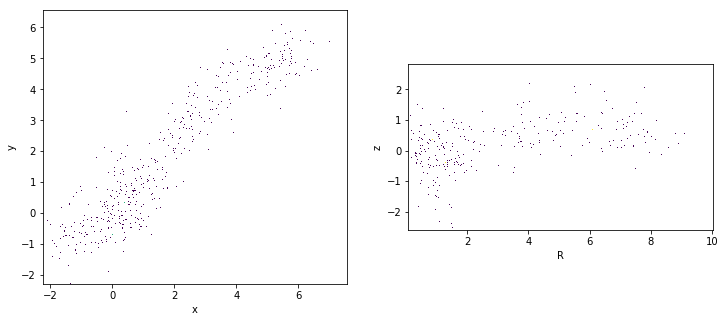

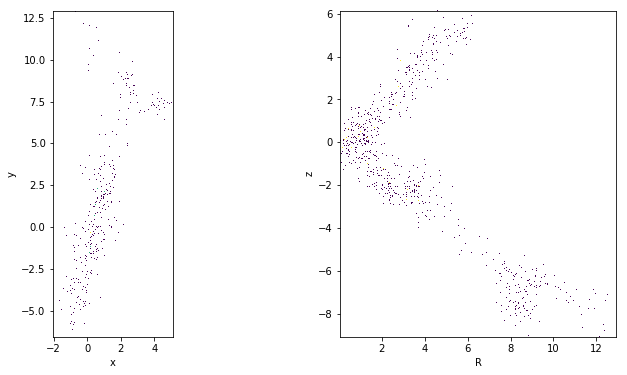

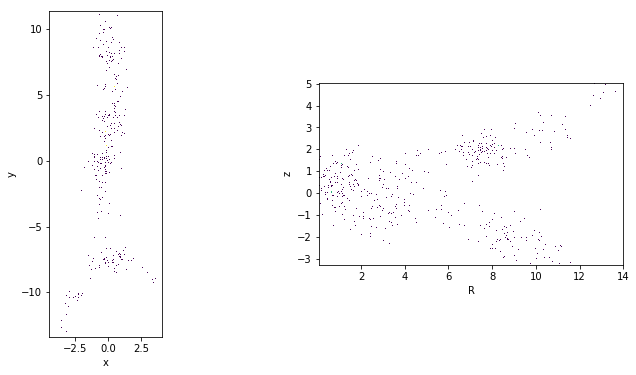

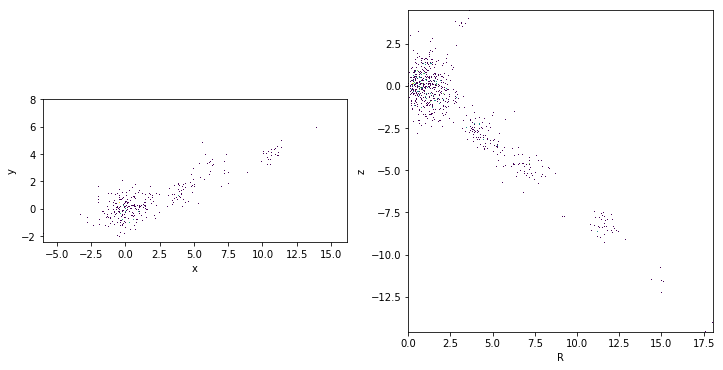

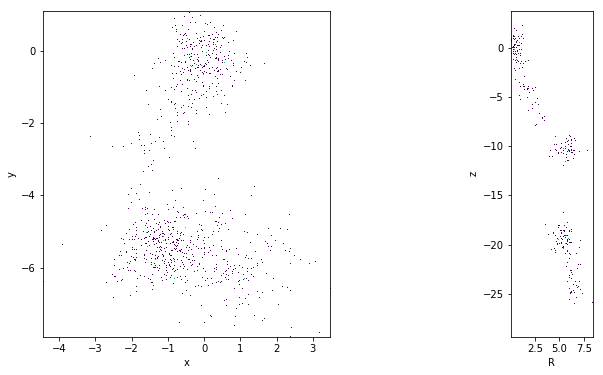

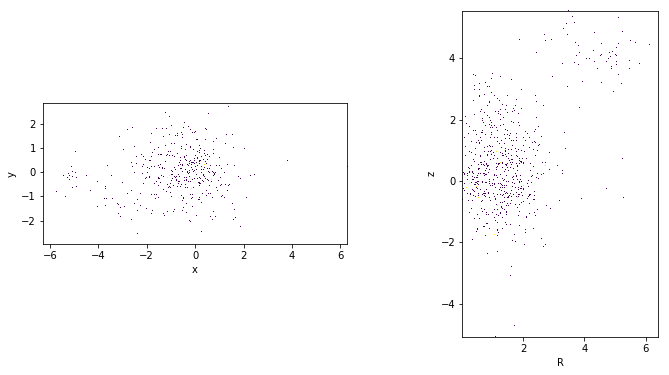

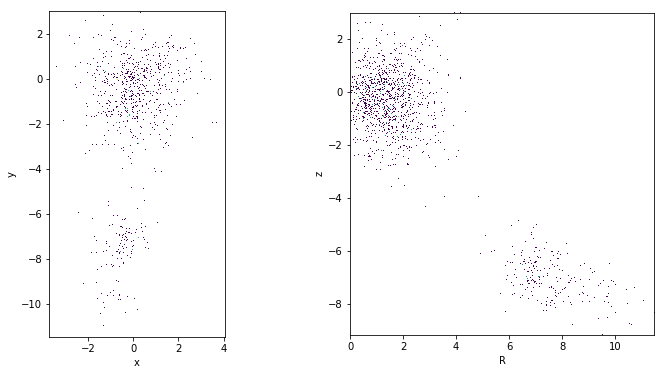

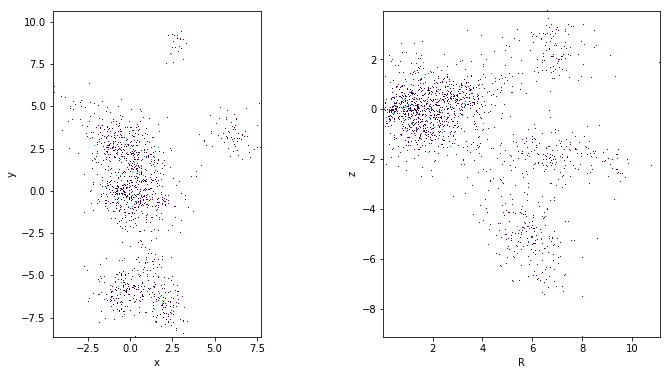

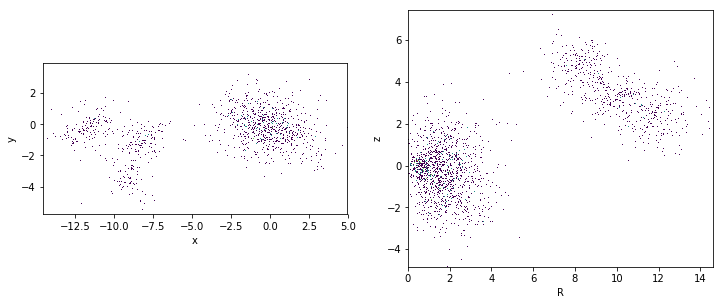

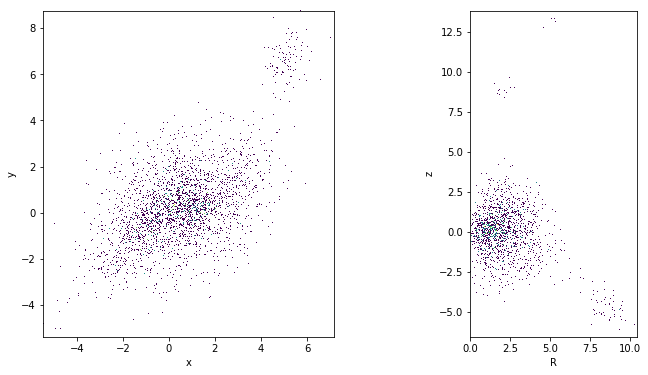

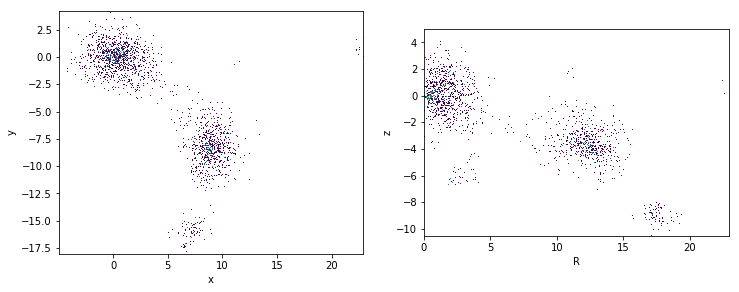

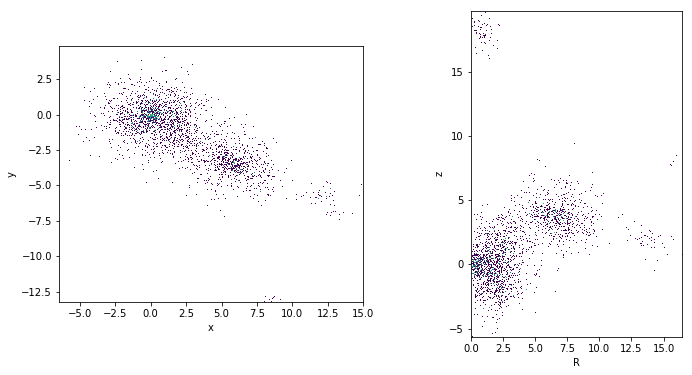

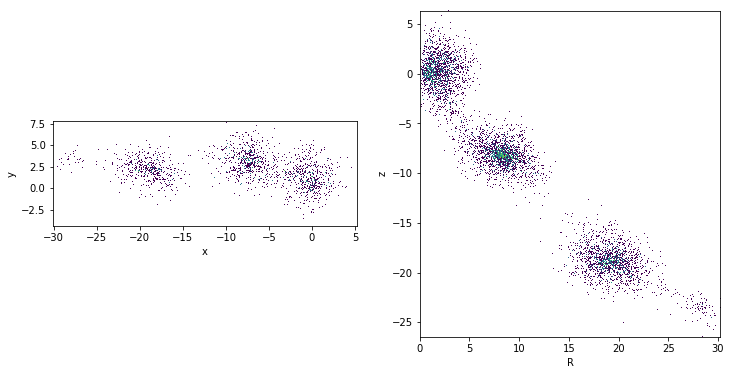

In [13]:
###### load several low res snapshots
level = 4
basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(29,42,1):
        '''
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        '''
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath,
            haloid=0, galradfac=0.1, verbose=False) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = numpy.maximum( s.data['gmet'], 1e-40 )
        


        istarssub, = numpy.where( (s.type == 4) & (s.halo == 0) & (s.subhalo == 2) )
        if j == 0:
            ids_halo1 = s.id[istarssub]
        j +=1
        istars, = numpy.where( (s.type == 4) & (s.halo == 0) )
        (x, y, z), (vx, vy, vz), rxyz, rxy, ids = get_cartesian_vectors(s, sf, istars)
        #xt, yt, zt = x[im], y[im], z[im]
        fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 6))
        try: 
            itrace1, itrace2, itrace3, itrace4, itrace5 = np.where(ids == ids_halo1[20]), \
            np.where(ids == ids_halo1[40]), np.where(ids == ids_halo1[60]), \
            np.where(ids == ids_halo1[80]), np.where(ids == ids_halo1[100]) 

            xt1, yt1, zt1, rxyt1 = x[itrace1], y[itrace1], z[itrace1], rxy[itrace1]
            xt2, yt2, zt2, rxyt2 = x[itrace2], y[itrace2], z[itrace2], rxy[itrace2]
            xt3, yt3, zt3, rxyt3 = x[itrace3], y[itrace3], z[itrace3], rxy[itrace3]
            xt4, yt4, zt4, rxyt4 = x[itrace4], y[itrace4], z[itrace4], rxy[itrace4]
            xt5, yt5, zt5, rxyt5 = x[itrace5], y[itrace5], z[itrace5], rxy[itrace5]

            ax1.hist2d(1000*x, 1000*y, bins=401, norm=matplotlib.colors.LogNorm())
            ax1.plot(1000*xt1, 1000*yt1, 'kX')
            ax1.plot(1000*xt2, 1000*yt2, 'yX')
            ax1.plot(1000*xt3, 1000*yt3, 'bX')
            ax1.plot(1000*xt4, 1000*yt4, 'gX')
            ax1.plot(1000*xt5, 1000*yt5, 'rX')
            ax1.set_xlabel("x")
            ax1.set_ylabel("y")
            ax1.set_aspect('equal')
            ax2.hist2d(1000*rxy, 1000*z, bins=401, norm=matplotlib.colors.LogNorm())
            ax2.plot(1000*rxyt1, 1000*zt1, 'kX')
            ax2.plot(1000*rxyt2, 1000*zt2, 'yX')
            ax2.plot(1000*rxyt3, 1000*zt3, 'bX')
            ax2.plot(1000*rxyt4, 1000*zt4, 'gX')
            ax2.plot(1000*rxyt5, 1000*zt5, 'rX')
            ax2.set_xlabel("R")
            ax2.set_ylabel("z")
            ax2.set_aspect('equal')
            fig.show()
        except IndexError:
            ax1.hist2d(1000*x, 1000*y, bins=401, norm=matplotlib.colors.LogNorm())
            ax1.set_xlabel("x")
            ax1.set_ylabel("y")
            ax1.set_aspect('equal')
            ax2.hist2d(1000*rxy, 1000*z, bins=401, norm=matplotlib.colors.LogNorm())
            ax2.set_xlabel("R")
            ax2.set_ylabel("z")
            ax2.set_aspect('equal')
            fig.show()



In [ ]:
istars, = numpy.where( (s.type == 4) & (s.halo == 0) & (s.subhalo == 0))

(x, y, z), (vx, vy, vz), rxyz, rxy, ids = get_cartesian_vectors(s, sf, istars)

#plt.plot(1000*rxy, s.pot[istars], '.', colop)
#plt.hist(s.pot[istars], bins = 101)
plt.hist2d(1000*rxy, s.pot[istars], bins=401, norm=matplotlib.colors.LogNorm())

plt.xlabel('r [kpc]')
plt.ylabel('pot')
plt.show()


In [ ]:
sf.data['scmp'].shape

In [ ]:
com = s.getCenterOfMass()
angc = s.getAngularMomentumCore()

In [ ]:
'''
s.id should be super useful following a particle through the different snapshots
buuut: 
    find the fastest way to compare a list of subsets to the main Id list (containing more than 4million IDs)
    it can happen that some particles are created along the way and not there from the beginning
'''
s.id

In [ ]:
# I think this is the number of subhalos of the 0th halo.
Nsubhalos = sf.data['fnsh'][0] # = 917
print('Number of subhalos:', Nsubhalos)

# this is the number of stars of each subhalo... as I see most of them are just DM (maybe gas) subhalos
subhalosLenStars = sf.data['slty'][0:Nsubhalos,4]
#print(subhalosLenStars)

# select subhalos containing stars
isubs, = np.where(subhalosLenStars > 0)
print(isubs)

In [ ]:
# try something with GIGAGALAXY tool
import sys
sys.path.append('/Users/smilanov/Documents/repos/the-gigagalaxy-project-analysis-tool/')

from projections import stellar_projections_timeseries

In [ ]:
s.calc_sf_indizes( sf)

In [ ]:
istars, = numpy.where( (s.type == 4) )
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)

fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 6))
ax1.plot(1000*x, 1000*y, "kD", ms=1, alpha=0.1)
ax1.set_xlabel("x [kpc]")
ax1.set_ylabel("y [kpc]")

ax2.plot(1000*rxy, 1000*z, "kD", ms=1, alpha=0.1)
ax2.set_xlabel("R [kpc]")
ax2.set_ylabel("z [kpc]")

In [ ]:
istars, = numpy.where( (s.type == 4) & (s.halo == 0) )
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)
#xt, yt, zt = x[im], y[im], z[im]
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 6))

ax1.hist2d(1000*x, 1000*y, bins=401, norm=matplotlib.colors.LogNorm())
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_aspect('equal')
ax2.hist2d(1000*rxy, 1000*z, bins=401, norm=matplotlib.colors.LogNorm())
ax2.set_xlabel("R")
ax2.set_ylabel("z")
ax2.set_aspect('equal')


In [ ]:
istars, = numpy.where( (s.type == 4) & (s.halo == 0) & (s.r() > 10*s.galrad) )
# check if exclusion of central galaxy is necessary
(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, istars)

import sklearn.cluster as cl
# n_cluster = 7 was better
X = numpy.vstack((x,y,z)).T
kmeans = cl.KMeans(n_clusters=9).fit(X)
centers = kmeans.cluster_centers_

In [ ]:
print(np.shape(centers))

In [ ]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 6))

ax1.plot(x, y, "kD", ms=1, alpha=0.1, c = 'yellow')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.scatter(centers[ :, 0], centers[:,1], c = 'red', zorder = 5)
ax2.plot(x, z, "kD", ms=1, alpha=0.1)
ax2.scatter(centers[:,0],centers[:,2], c='red', zorder = 5)
ax2.set_xlabel("R")
ax2.set_ylabel("z")

In [ ]:
hist, xedges, yedges = numpy.histogram2d(1000.*x[istars], 1000.*y[istars], bins = 100)
#maxval = numpy.max(hist)
maxindex = (-hist).argsort()
maxhist = (-hist).sort()

for i, item in enumerate(maxhist):
    ind = hist.index(item)
    targetval = 0.1*item
    outinds = np.where(hist < targetval)
    #foundinds = bisect()
    
    if i == 20: break
    

In [ ]:
ids, ty, x, y, z, vx, vy, vz, m = np.loadtxt('../data/level_5_halo_24_snapshot_63_data.txt', unpack = True, usecols = (0,1,2,3,4,5,6,7,8))

In [ ]:
ids